In [1]:
import uproot
import numpy as np
import awkward as ak
from numba import njit
from scipy.interpolate import CubicSpline
import ROOT

Loading CENNSMC Root Utilities


TFile::Init:0: RuntimeWarning: no StreamerInfo found in /geode2/home/u015/bojohn/Quartz/cohar750_sim/builddir/lib/libcenns_io_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.28/04, while the current version is 6.32.02
Error in <TUnixSystem::Load>: version mismatch, /geode2/home/u015/bojohn/Quartz/cohar750_sim/builddir/lib/libcenns_io.so = 62804, ROOT = 63202


In [2]:
with uproot.open("../data/cohar750_cevns_sim_output.root:CENNS") as cenns:
    en = cenns['en'].array()
    chans = cenns['chans'].array()
    top = cenns['top'].array()
z = ak.zip({"en": en, "chans": chans, "top": top}, depth_limit=1)

In [4]:
x, y = np.loadtxt("../data/sns_diff_rates-cohar750-Ar-klein-Ar40.out", unpack=True)
x *= 1000
y /= 1000
spl = CubicSpline(x, y)
h_cevnspred = ROOT.TH1F("h_cevnspred", "COHAr750 CEvNS Prediction;True energy [keVr];Events", 100, 0, 200)
# h_cevnspred.GetXaxis().SetTitle("Recoil energy [keVr]")
# h_cevnspred.GetYaxis().SetTitle("Events")
h_cevnspred.Sumw2()
bin_width = h_cevnspred.GetBinWidth(1)
nbins = h_cevnspred.GetNbinsX()
for b in range(1, nbins+1):
    center = h_cevnspred.GetBinCenter(b)
    h_cevnspred.SetBinContent(b, spl(center) * bin_width)
    h_cevnspred.SetBinError(b, np.sqrt(spl(center) * bin_width))
h_cevnspred.Integral()

9136.77710480621

Warning in <TROOT::Append>: Replacing existing TH1: h_cevnspred (Potential memory leak).


Info in <TCanvas::Print>: png file ../plots/cohar750_cevnspred.png has been created


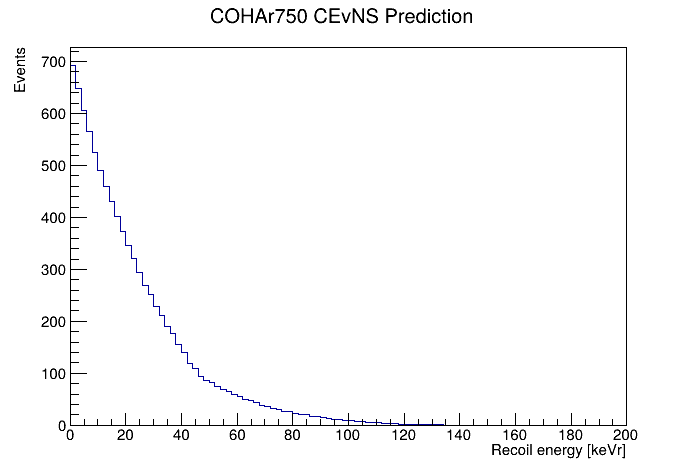

In [5]:
# %jsroot on
c1 = ROOT.TCanvas()
h_cevnspred.SetStats(0)
h_cevnspred.Draw("hist")
# h_cevnspred.Draw()
c1.Draw()
c1.SaveAs("../plots/cohar750_cevnspred.png")

In [6]:
h_sim = ROOT.TH1F("h_sim", "Simulation energies;True energy [keVr];Counts", 100, 0, 200)
h_sim.FillN(len(z['en']), np.array(z['en'] * 1000), np.ones(len(z['en'])))

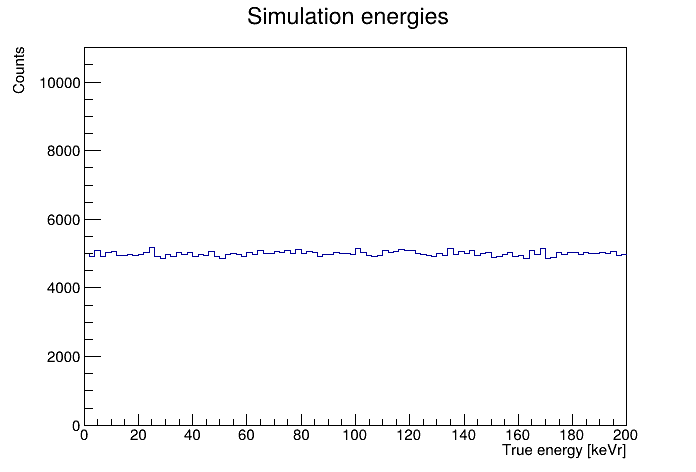

In [7]:
# %jsroot on
c2 = ROOT.TCanvas()
h_sim.SetStats(0)
h_sim.GetYaxis().SetRangeUser(0, 11000)
h_sim.Draw("hist")
ROOT.gPad.SetLeftMargin(0.12)
# h_cevnspred.Draw()
# c2.Draw()
c2.Update()

In [8]:
h3 = h_cevnspred / h_sim

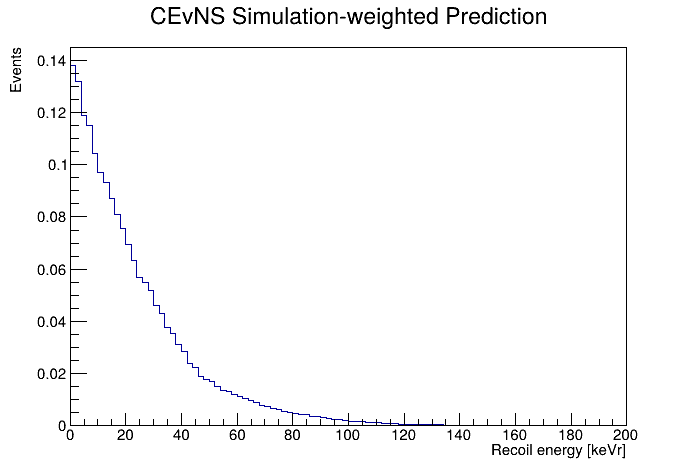

In [9]:
# %jsroot on
c3 = ROOT.TCanvas()
h3.SetStats(0)
h3.SetTitle("CEvNS Simulation-weighted Prediction")
h3.Draw("hist")
c3.Update()

In [10]:
h3.FindBin(20.1)
h3.GetBinContent(6)

0.09715287387371063

## Look at true energy vs num hits and fit

In [11]:
@njit
def detector_response(events, rng):
    lys = []
    ens = []
    sigma = 0.44
    for event in events:
        ly = []
        top_pes = []
        bot_pes = []
        for top, chan in zip(event['top'], event['chans']):
            smeared_pes = rng.normal(1.0, sigma, len(chan))
            smeared_pes[smeared_pes < 0.0] = 0.0
            if top:
                # top_pes.append(len(chan))
                top_pes.append(np.sum(smeared_pes))
            else:
                # bot_pes.append(len(chan))
                bot_pes.append(np.sum(smeared_pes))
            # ly.append(len(chan))
            ly.append(np.sum(smeared_pes))
        if sum(top_pes) >= 2 and sum(bot_pes) >= 2:
            lys.append(sum(ly))
            ens.append(event['en'] * 1000)
    return np.array(lys), np.array(ens)

In [12]:
rng = np.random.default_rng(1234)
lys, ens = detector_response(z, rng)

In [13]:
h_resp = ROOT.TH2F("h_resp", "COHAr750 Ar40 Response;PEs;True energy [keVr]", 250, 0, 500, 100, 0, 200)
h_resp.FillN(len(ens), lys.astype(float), ens, np.ones(len(ens)))

****************************************
         Invalid FitResult  (status = 3 )
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      33942.4
NDf                       =          245
Edm                       =      8.68444
NCalls                    =          873
p0                        =     0.424792   +/-   2.47441      	 (limited)
p1                        =  -0.00352117   +/-   1.41992      	 (limited)
p2                        =      1.75707   +/-   114.729      	 (limited)


Warning in <Fit>: Abnormal termination of minimization.
Info in <TCanvas::Print>: png file ../plots/cohar750_ar40resp.png has been created


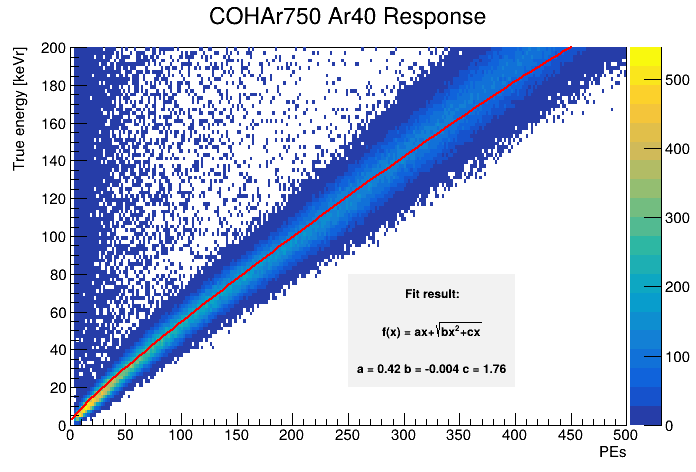

In [14]:
# %jsroot on
c4 = ROOT.TCanvas()
profx = h_resp.ProfileX()
fit_func = ROOT.TF1("cevns_fit", "[0] * x + sqrt([1] * x^2 + [2] * x)", 0, 500)
fit_func.SetParameters(0.25, 0.25, 4.0)
fit_func.SetParLimits(0, 0.1, 5.0)
fit_func.SetParLimits(1, -1, 1)
fit_func.SetParLimits(2, 0, 200)
profx.Fit(fit_func, "R")
h_resp.Draw("colz")
h_resp.SetStats(0)
fit_func.Draw("same")
tpave = ROOT.TPaveText(250, 20, 400, 80, "user")
tpave.AddText("Fit result:")
tpave.AddText("f(x) = ax+#sqrt{bx^{2}+cx}")
tpave.AddText(f"a = {fit_func.GetParameter(0):0.2f} b = {fit_func.GetParameter(1):0.3f} c = {fit_func.GetParameter(2):0.2f}")
tpave.Draw("same")
c4.Update()
c4.SaveAs("../plots/cohar750_ar40resp.png")

## Create CEvNS PDF using photon smearing

In [15]:
@njit
def event_cut(z, rng):
    lys = []
    ens = []
    sigma = 0.44
    for event in z:
        en = event['en'] * 1000
        ly = []
        top_pes = []
        bot_pes = []
        for top, chan in zip(event['top'], event['chans']):
            smeared_pes = rng.normal(1.0, sigma, len(chan))
            smeared_pes[smeared_pes < 0.0] = 0.0
            if top:
                top_pes.append(np.sum(smeared_pes))
            if not top:
                bot_pes.append(np.sum(smeared_pes))
            ly.append(np.sum(smeared_pes))
        if sum(top_pes) >= 2 and sum(bot_pes) >= 2:
            lys.append(sum(ly))
            ens.append(en)
    return np.array(lys), np.array(ens)

In [16]:
rng = np.random.default_rng(1234)
lys, ens = event_cut(z, rng)
h_cevns = ROOT.TH1F("h_cevns", "CEvNS Signal Prediction;Recon. energy [keVr];Counts", 100, 0, 200)
for ly, en in zip(lys, ens):
    reco_en = fit_func.Eval(ly)
    weight_bin = h3.FindBin(en)
    weight = h3.GetBinContent(weight_bin)
    h_cevns.Fill(reco_en, weight)
    # h_cevns.Fill(en, weight)

Info in <TCanvas::Print>: png file ../plots/cohar750_cevnsresp_keVr.png has been created


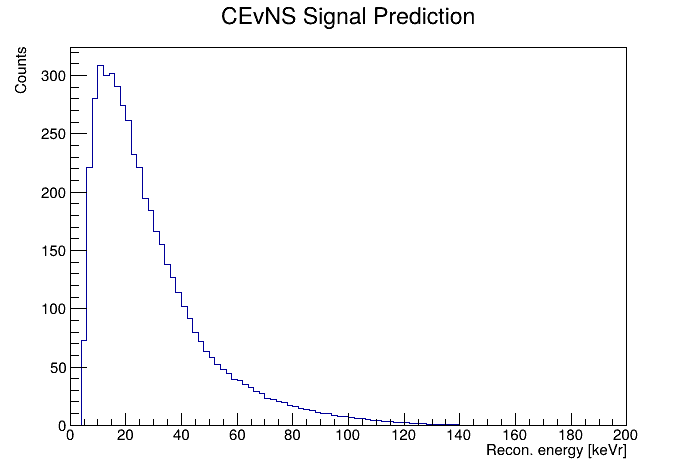

In [17]:
# %jsroot on
c5 = ROOT.TCanvas()
h_cevns.SetStats(0)
h_cevns.Draw("hist")
c5.Update()
c5.SaveAs("../plots/cohar750_cevnsresp_keVr.png")

In [18]:
h_cevns.Integral()
# b1 = h_cevns.FindBin(0)
# b2 = h_cevns.FindBin(40)
# h_cevns.Integral(b1, b2)

4925.151749106882

## Apply QF

In [19]:
def qf(e):
    if e < 100 and e > 0:
        return 0.251 + 0.000752 * e
    else:
        return 0.3262

In [20]:
# rng = np.random.default_rng(1234)
# lys, ens = event_cut(z, rng)
h_cevns_quench = ROOT.TH1F("h_cevns_quench", "COHAr750 CEvNS Signal Prediction;Recon. energy [keVee];Counts", 40, 0, 40)
for ly, en in zip(lys, ens):
    reco_en = fit_func.Eval(ly)
    weight_bin = h3.FindBin(en)
    weight = h3.GetBinContent(weight_bin)
    h_cevns_quench.Fill(reco_en * qf(reco_en), weight)
    # h_cevns.Fill(en, weight)

Info in <TCanvas::Print>: png file ../plots/cohar750_cevnsresp_keVee.png has been created


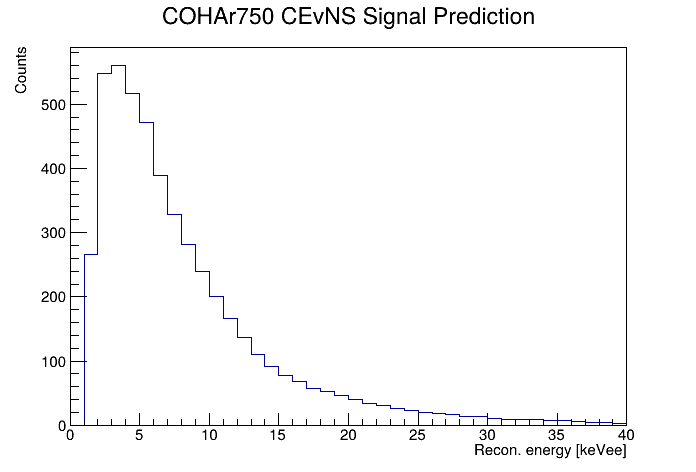

In [21]:
# %jsroot on
c6 = ROOT.TCanvas()
h_cevns_quench.SetStats(0)
h_cevns_quench.Draw("hist")
c6.Draw()
c6.SaveAs("../plots/cohar750_cevnsresp_keVee.png")

In [22]:
h_cevns_quench.Integral()

4916.738880157471

In [21]:
f = ROOT.TFile("../data/cohar750_cevns.root", "recreate")
h_cevns.Write()
h_cevnspred.Write()
h_cevns_quench.Write()
fit_func.Write()
f.Close()